Epoch[1/25], G Loss: 0.3731, D Loss: 0.0641


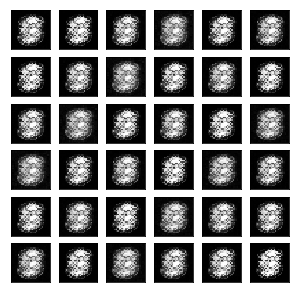

Epoch[2/25], G Loss: 0.3556, D Loss: 0.0442


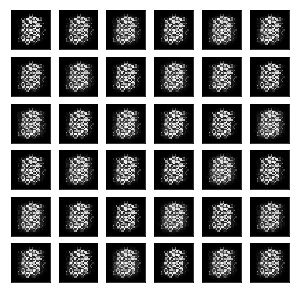

Epoch[3/25], G Loss: 0.3446, D Loss: 0.0366


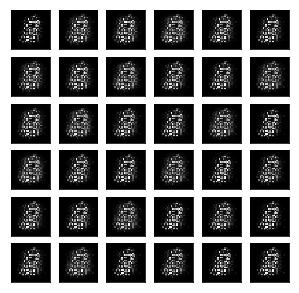

Epoch[4/25], G Loss: 0.2789, D Loss: 0.0690


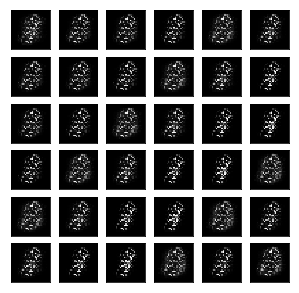

Epoch[5/25], G Loss: 0.3069, D Loss: 0.0549


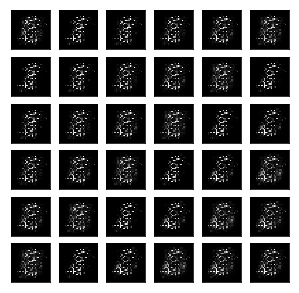

Epoch[6/25], G Loss: 0.3436, D Loss: 0.0462


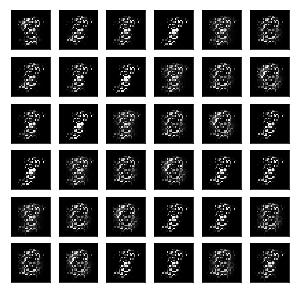

Epoch[7/25], G Loss: 0.3660, D Loss: 0.0408


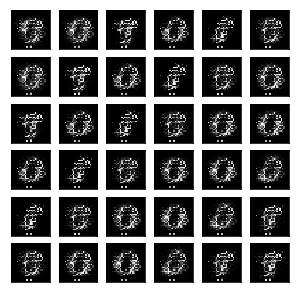

Epoch[8/25], G Loss: 0.3766, D Loss: 0.0396


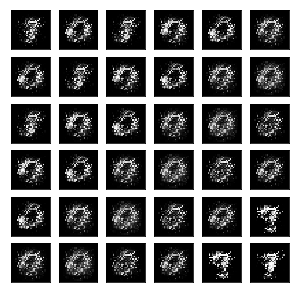

Epoch[9/25], G Loss: 0.3778, D Loss: 0.0500


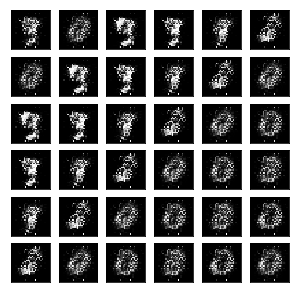

Epoch[10/25], G Loss: 0.3544, D Loss: 0.0726


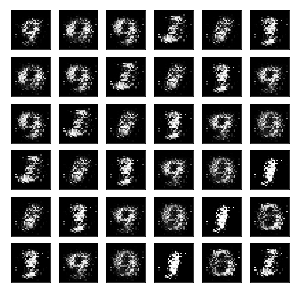

Epoch[11/25], G Loss: 0.3570, D Loss: 0.0643


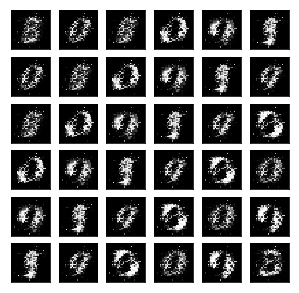

Epoch[12/25], G Loss: 0.3672, D Loss: 0.0503


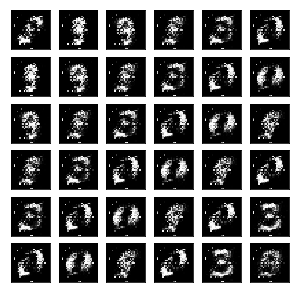

Epoch[13/25], G Loss: 0.3755, D Loss: 0.0445


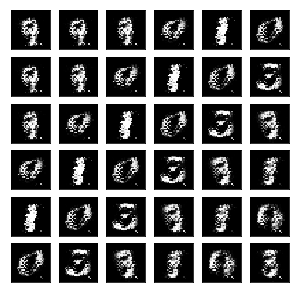

Epoch[14/25], G Loss: 0.3662, D Loss: 0.0570


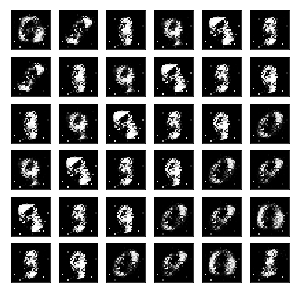

Epoch[15/25], G Loss: 0.3498, D Loss: 0.0661


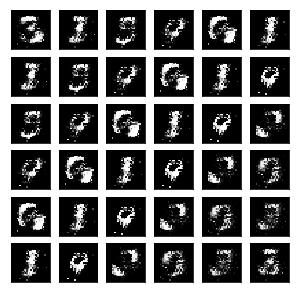

Epoch[16/25], G Loss: 0.3526, D Loss: 0.0654


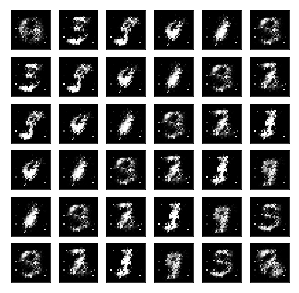

Epoch[17/25], G Loss: 0.3446, D Loss: 0.0705


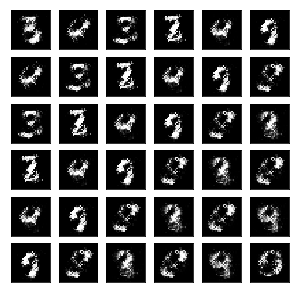

Epoch[18/25], G Loss: 0.3540, D Loss: 0.0545


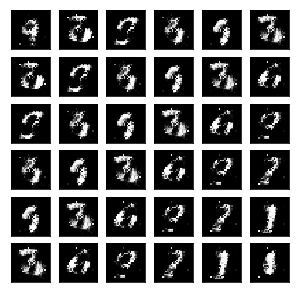

Epoch[19/25], G Loss: 0.3652, D Loss: 0.0478


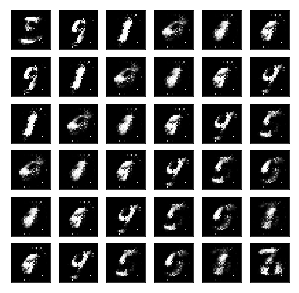

Epoch[20/25], G Loss: 0.3589, D Loss: 0.0486


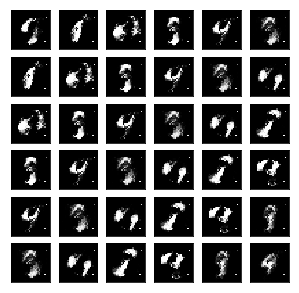

Epoch[21/25], G Loss: 0.3703, D Loss: 0.0410


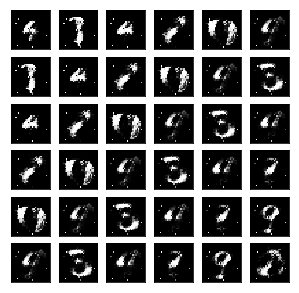

Epoch[22/25], G Loss: 0.3762, D Loss: 0.0401


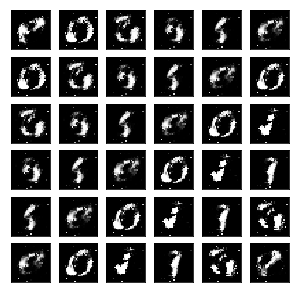

Epoch[23/25], G Loss: 0.3728, D Loss: 0.0438


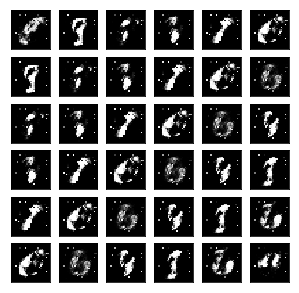

Epoch[24/25], G Loss: 0.3815, D Loss: 0.0408


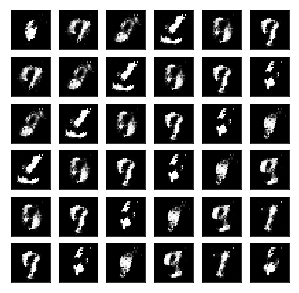

Epoch[25/25], G Loss: 0.3798, D Loss: 0.0420


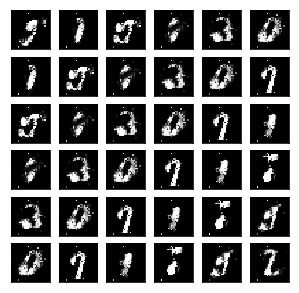

In [1]:
""" (LS GAN)
Least Squares GAN

https://arxiv.org/pdf/1611.04076.pdf

The output of LSGAN's D is unbounded unless passed through an activation function. In this 
implementation, we include a sigmoid activation function as this empirically improves 
visualizations for binary MNIST.

Tackles the vanishing gradients problem associated with GANs by swapping out
the cross entropy loss function with the least squares (L2) loss function. The authors
show that minimizing this objective is equivalent to minimizing the Pearson chi-squared 
divergence. They claim that using the L2 loss function penalizes samples that appear to 
be real to the discriminator, but lie far away from the decision boundary. In this way, 
the generated images are made to appear closer to real data. It also stabilizes training.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is approximate least-squares divergence.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination


class LSGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class LSGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz

    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=1):
        """ Train a least-squares GAN with Gradient Penalty
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the least-squares distance between real, generated
                    # distributions                    
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated least-squares distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()       
                        
    def train_D(self, images, a=0, b=1):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: L2 loss for discriminator, 
            0.50 * E[(D(x) - a)^2] + 0.50 * E[(D(G(z)) - b)^2], 
            where a and b are labels for generated (0) and real (1) data
        """ 
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = self.model.D(images) # D(x)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute L2 loss for D
        D_loss = (0.50 * torch.mean((DX_score - b)**2)) + (0.50 * torch.mean((DG_score - a)**2))
        
        return D_loss
    
    def train_G(self, images, c=1):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images (reshaped to [batch_size, -1])   
        Output:
            G_loss: L2 loss for G, 
            0.50 * E[(D(G(z)) - c)^2], 
            where c is the label that G wants D to believe for fake data (i.e., 1)
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute L2 loss for G,
        G_loss = 0.50 * torch.mean((DG_score - c)**2)
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = LSGAN(image_size=784, 
              hidden_dim=256, 
              z_dim=128)

trainer = LSGANTrainer(model=model, 
                       train_iter=train_iter, 
                       val_iter=val_iter, 
                       test_iter=test_iter,
                       viz=True)

trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)